# Boosting 이란?

- 여러개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법중 하나이다.
- 즉, 약한 예측모델들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측 모델을 만드는 것이다

# GMB(Gradient Boosting Machine)

- GBM은 여러 개의 weak learner를 순착적으로 학습, 예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치의 업데이트 방법은 **경사 하강법(Gradient Descent)**을 사용한다.

# XGBoost 란?

- XGBoost는 Extreme Gradient Boosting의 약자이다.
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost가 대표적인데 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다.
- Regression, Classifier 문제를 모두 지원하며, 성능과 자원 효율이 좋아서 인기 있는 알고리즘이다.
- XGBoost의 장점
    1. GBM 대비 빠른 수행시간 : 병렬 처리로 학습, 분류 속도가 빠르다
    2. 과적합 규제(Regularization) : 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성을 지닌다.
    3. 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘한다.
        - 즉, CART(Classifier and Regression Tree)앙상블 모델을 사용한다.
    4. Early Stopping(조기종료) 기능이 있다.
    5. 다양한 옵션을 제공하며 Customizing이 용이하다.

## 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family = 'D2coding')
# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus = False)

warnings.filterwarnings('ignore')

# 로지스틱 회귀와 평가지표

## 데이터셋 - 위스콘신 유방암 예측

In [3]:
!pip install xgboost

In [4]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
X = cancer.data
y = cancer.target

cancer_df = pd.DataFrame(data = X, columns = cancer.feature_names)
cancer_df['target'] = y
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
## 정규화가 필요한것으로 보임

In [7]:
print('data shape : ', X.shape)
print('target shape : ', y.shape)

data shape :  (569, 30)
target shape :  (569,)


In [8]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [9]:
# 양성 유방암세트와 음성 유방암세트 개수의 파악
np.unique(cancer.target, return_counts = True)

(array([0, 1]), array([212, 357], dtype=int64))

In [10]:
# 30개의 feature가 뭔지를 확인
for i, feature in enumerate(cancer.feature_names):
    print(f'feature{i+1} : ', feature)

feature1 :  mean radius
feature2 :  mean texture
feature3 :  mean perimeter
feature4 :  mean area
feature5 :  mean smoothness
feature6 :  mean compactness
feature7 :  mean concavity
feature8 :  mean concave points
feature9 :  mean symmetry
feature10 :  mean fractal dimension
feature11 :  radius error
feature12 :  texture error
feature13 :  perimeter error
feature14 :  area error
feature15 :  smoothness error
feature16 :  compactness error
feature17 :  concavity error
feature18 :  concave points error
feature19 :  symmetry error
feature20 :  fractal dimension error
feature21 :  worst radius
feature22 :  worst texture
feature23 :  worst perimeter
feature24 :  worst area
feature25 :  worst smoothness
feature26 :  worst compactness
feature27 :  worst concavity
feature28 :  worst concave points
feature29 :  worst symmetry
feature30 :  worst fractal dimension


## standarization(표준화)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cancer_df.drop('target', axis = 1))

## 훈련세트와 테스트세트 분리

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled,
                                                   cancer_df['target'], test_size = 0.2, random_state = 156)

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()  ## (C = 20, max_iter = 100)
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.989010989010989
0.9736842105263158


In [14]:
lr.predict(X_train[:5])

array([0, 1, 1, 1, 1])

In [15]:
proba = lr.predict_proba(X_train[:5])
np.round(proba, decimals = 3)

array([[0.991, 0.009],
       [0.04 , 0.96 ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.087, 0.913]])

In [16]:
lr.classes_

array([0, 1])

In [17]:
# 로지스틱 회귀가 학습한 계수(기울기와 절편) 추출
print(lr.coef_)

[[-0.4721854  -0.38258173 -0.44454406 -0.54316124 -0.14319742  0.72706363
  -0.70746211 -0.96418695 -0.07905176  0.27001329 -1.19658305  0.19765208
  -0.5890956  -0.95010481 -0.31150744  0.75959144  0.14533365 -0.32546344
   0.33243796  0.4394735  -0.86822466 -1.27824666 -0.65146591 -0.90866007
  -0.44631307  0.16705142 -0.8564404  -0.83122684 -1.0734741  -0.54801513]]


In [18]:
# 예측한 5개의 z값 출력
decisions = lr.decision_function(X_train[:5])
print(decisions)

[-4.66877599  3.18944318 11.91185818  8.7300568   2.34636033]


In [19]:
from scipy.special import expit
print(expit(decisions))

[0.00929651 0.96043507 0.99999329 0.99983837 0.91264449]


In [20]:
# 예측하기
predict = lr.predict(X_test)

## 평가지표
1. 회귀(regression): MAE, MSE, RMSE, SSE...
2. 분류(Classification) : 정확도, 정밀도, 재현율(민감도), F1스코어, ROC커브
3. 클러스터링(Clustering) : DBI, 엘보우 메서드, 실루엣계수

In [21]:
# 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
# 이진 분류일 경우 데이터에 따라(불균형한 데이터 세트) 모델의 성능이 왜곡 될 수 있다.
# 정확도 - 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.9736842105263158

## 혼돈 행렬(Confusion matrix, 오차행렬)

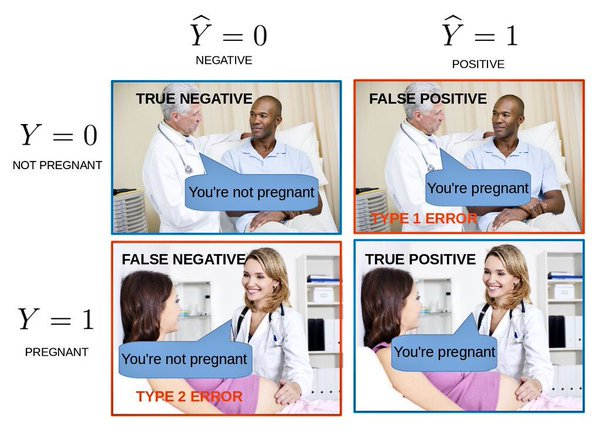

In [22]:
from IPython.display import Image
Image('https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg', width = 600)

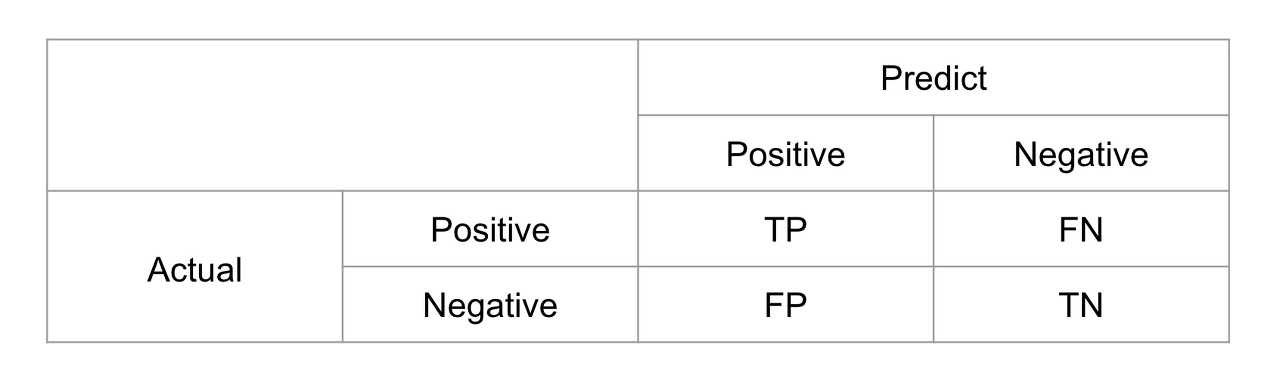

In [23]:
from IPython.display import Image
Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fx3c4F%2FbtqDn2lU1Ab%2FVAxPJQcU0rYgnxmZlTnYdk%2Fimg.png', width = 600)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
cm

array([[35,  2],
       [ 1, 76]], dtype=int64)

Text(33.0, 0.5, 'Actual')

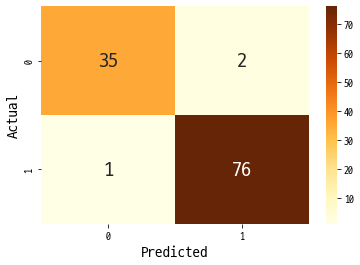

In [25]:
# 혼돈 행렬 시각화
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, cmap = 'YlOrBr')
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)

In [26]:
TN, FP, FN, TP = cm.ravel()

### 정밀도(Precision)
- Positive로 예측한 전체 건수에서 옳게 예측한 건수의 비율

In [27]:
precision = TP / (FP + TP)
precision

0.9743589743589743

In [28]:
from sklearn.metrics import precision_score
precision_score(y_test, predict)

0.9743589743589743

### 재현율(Recall), 민감도
- 실제 Positive인 전체 건수에서 옳게 예측한 건수의 비율
- TPR(True Positive Rate)

In [29]:
recall = TP / (FN + TP)
recall

0.987012987012987

In [30]:
from sklearn.metrics import recall_score
recall_score(y_test, predict)

0.987012987012987

### F1 Score
- 재현율과 정밀도의 평균을 나타내는 수치

In [31]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.9806451612903225

In [32]:
from sklearn.metrics import f1_score
f1_score(y_test, predict)

0.9806451612903225

### ROC Curve
- 평가해보기

# XGBoost 모델 학습

In [33]:
import xgboost as xgb
from xgboost import plot_importance

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

In [34]:
cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [35]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

## 악성종양'malignant'(0) 일반 양성종양'benign'(1)

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [36]:
# cancer_df 에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer)df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 : -1 슬라이싱
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [37]:
# 학습 80% 테스트 20%
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state =156)

In [38]:
# 학습 中 => 서브학습 90%, 검증 10%

In [39]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

## 569개 데이터셋에서 최종학습(tr) 409개/ 검증용(val) 46개/테스트용(test) 114개 추출

(455, 30) (114, 30)
(409, 30) (46, 30)


In [63]:
y_train

172    0
160    1
173    1
504    1
476    1
      ..
55     1
10     0
485    1
418    1
556    1
Name: target, Length: 455, dtype: int32

In [41]:
## df => DMatrix로 변환(XGBoost의 훈련 데이터 객체)

In [42]:
dtr = xgb.DMatrix(data = X_tr, label = y_tr)

In [43]:
dval = xgb.DMatrix(data = X_val, label = y_val)

In [44]:
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [45]:
## 하이퍼 파라미터 설정

In [46]:
params = { 'max_depth' : 3,
         'eta' : 0.05,
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss'}

num_rounds = 400

In [47]:
## 조기중단 설정 및 모델훈련

In [48]:
eval_list = [(dtr,'train'),(dval,'eval')]

In [49]:
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, \
                     early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086


In [50]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]


In [51]:
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]

In [52]:
print(preds[:10])

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [53]:
from sklearn.metrics import roc_auc_score  ## AUC 점수 함수

In [54]:
from sklearn.metrics import roc_auc_score  ## AUC 점수 함수

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도 : {0:.3f}, 정밀도 : {1:.3f}, 재현율 : {2:.3f}, \
    F1 : {3:.3f}, AUC : {4:.3f}'.format(accuracy, precision, recall, f1, roc_auc))

In [55]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.956, 정밀도 : 0.962, 재현율 : 0.974,     F1 : 0.968, AUC : 0.994


In [56]:
## f스코어??
# 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지를 지표로 나타낸 값

In [57]:
## xgb_model : 훈련한 모델이름

In [58]:
# dtr = xgb.DMatrix(data = X_tr, label = y_tr)
# dval = xgb.DMatrix(data = X_val, label = y_val)
# dtest = xgb.DMatrix(data = X_test, label = y_test)

In [59]:
from xgboost import XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가
import pandas as pd

In [60]:
model = XGBClassifier()
model.fit(X=X_tr, y=y_tr)
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [61]:
fscore = model.get_booster().get_fscore()
fscore

{'mean radius': 2.0,
 'mean texture': 13.0,
 'mean area': 1.0,
 'mean smoothness': 9.0,
 'mean compactness': 2.0,
 'mean concavity': 3.0,
 'mean concave points': 14.0,
 'mean symmetry': 2.0,
 'mean fractal dimension': 2.0,
 'radius error': 5.0,
 'texture error': 2.0,
 'perimeter error': 1.0,
 'area error': 26.0,
 'compactness error': 7.0,
 'concave points error': 7.0,
 'symmetry error': 11.0,
 'fractal dimension error': 5.0,
 'worst radius': 9.0,
 'worst texture': 29.0,
 'worst perimeter': 16.0,
 'worst area': 9.0,
 'worst smoothness': 11.0,
 'worst compactness': 1.0,
 'worst concavity': 8.0,
 'worst concave points': 11.0,
 'worst symmetry': 14.0,
 'worst fractal dimension': 1.0}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

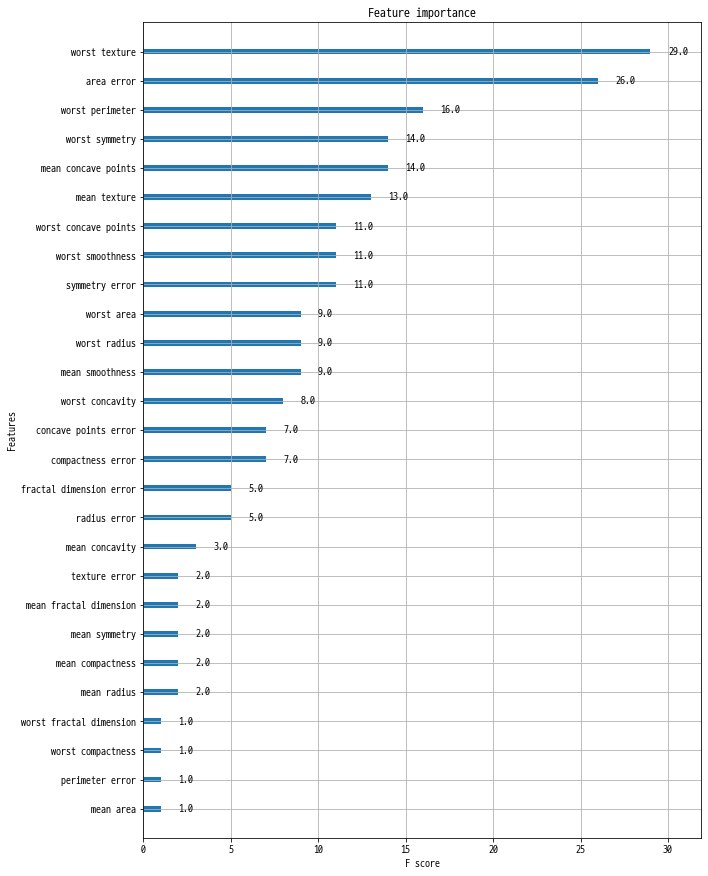

In [62]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True


plot_importance(model)